**Problem Description:**

The challenge is a binary image classification task aimed at detecting metastatic cancer in small image patches extracted from larger digital pathology scans. Specifically, the goal is to develop an algorithm that can accurately classify these patches as either containing metastatic cancer (positive label) or not (negative label). The presence of cancer is determined solely by the presence of tumor tissue within the center 32x32 pixel region of each patch. This task has significant clinical relevance, as it directly addresses the critical issue of cancer metastasis detection.

**Data Description:**

The dataset is a modified version of the PatchCamelyon (PCam) benchmark dataset. It consists of a large number of small, color pathology images. Will Cukierski. Histopathologic Cancer Detection. https://kaggle.com/competitions/histopathologic-cancer-detection, 2018. Kaggle.

-   **Size:** The dataset comprises thousands of image patches, split into training and testing sets.
-   **Dimension:** Each image patch has a fixed dimension of 96x96 pixels with 3 color channels (RGB).
-   **Structure:**
    -   The data (which is all stored in `data/`) is organized into two subdirectories: `train/` and `test/`.
    -   The `train` folder contains images for training the model, and the `test` folder contains images for which predictions are to be made.
    -   A `train_labels.csv` file provides the ground truth labels for the training images, mapping image IDs to binary labels (0 or 1).
    -   The labels are only determined by the center 32x32 pixel region of each image.
    -   The outer area of the 96x96 images are provided to support fully convolutional network architectures.
-   **Format:** Images are in standard image formats (tif).
-   **Class Imbalance:** It's important to note that the dataset exhibits class imbalance, with an unequal distribution of positive and negative samples.
-   **No Duplicates:** The Kaggle version of the PCam dataset has been processed to remove duplicate images, ensuring a cleaner training set.

In [ ]:
# --- Standard Libraries ---
import os
import io

# --- Data Manipulation & Visualization ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Image Processing & Augmentation ---
import cv2
import albumentations as A  # Efficient augmentations
from albumentations.pytorch import ToTensorV2  # Optional for conversion

# --- TensorFlow & Deep Learning ---
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses, metrics, callbacks
from tensorflow.keras.applications import ResNet50, EfficientNetB3  # Backbones
from tensorflow.keras.layers import (GlobalAveragePooling2D, Dense,
                                    Dropout, BatchNormalization, Input)
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # Legacy loader
from tensorflow.keras import backend as K
from tensorflow.keras.applications import ResNet50, EfficientNetB3

# --- Hyperparameter Tuning & Utilities ---
import keras_tuner as kt
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from PIL import Image, UnidentifiedImageError
from keras_tuner import HyperParameters as hp

In [ ]:
print("TensorFlow Version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

In [ ]:
# Load labels and check dataset size
train_labels = pd.read_csv('data/train_labels.csv')
train_dir = 'data/train'
print(f"Total training samples: {len(train_labels)}")
print(f"Test directory file count: {len(os.listdir('data/test'))}")  # Verify test size

In [ ]:
# Display the first few rows of the labels
print(train_labels.head())

In [ ]:
# Class distribution analysis
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='label', data=train_labels, palette='viridis')

# Add percentages to the plot
total = len(train_labels)
for p in ax.patches:
    percentage = f'{100 * p.get_height()/total:.1f}%'
    ax.annotate(percentage, (p.get_x() + p.get_width()/2, p.get_height()),
                ha='center', va='bottom', fontsize=12)

plt.title(f'Class Distribution (Total Samples: {total})', fontsize=14)
plt.xlabel('Class (0 = Negative, 1 = Positive)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

In [ ]:
# Numerical summary
class_counts = train_labels['label'].value_counts()
print(f"Class 0 (Negative): {class_counts[0]} samples ({class_counts[0]/total:.1%})")
print(f"Class 1 (Positive): {class_counts[1]} samples ({class_counts[1]/total:.1%})")

In [ ]:
# Get positive & negative samples
num_samples = 5
positive_samples = train_labels[train_labels['label'] == 1].sample(n=num_samples, random_state=42)
negative_samples = train_labels[train_labels['label'] == 0].sample(n=num_samples, random_state=42)

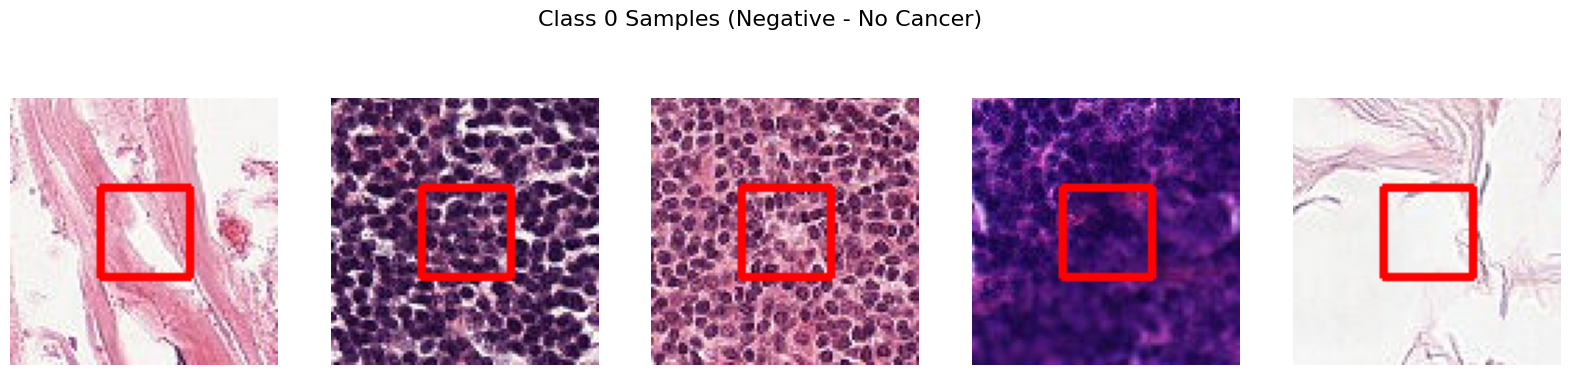

In [9]:
# Function to plot samples with center region highlighted
def plot_class_samples(df, class_label, num_samples=5, title_suffix=""):
    samples = df[df['label'] == class_label].sample(n=num_samples, random_state=42)
    fig, axes = plt.subplots(1, num_samples, figsize=(20, 4))
    fig.suptitle(f"Class {class_label} Samples {title_suffix}", y=1.05, fontsize=16)

    for ax, (idx, row) in zip(axes, samples.iterrows()):
        img = cv2.imread(os.path.join(train_dir, row['id'] + '.tif'))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Highlight center region
        cv2.rectangle(img, (32, 32), (64, 64), (255, 0, 0), 2)  # Red rectangle

        ax.imshow(img)
        ax.axis('off')
    plt.show()

# Plot both classes with consistent formatting
plot_class_samples(train_labels, 1, title_suffix="(Positive - Cancer Present)")
plot_class_samples(train_labels, 0, title_suffix="(Negative - No Cancer)")

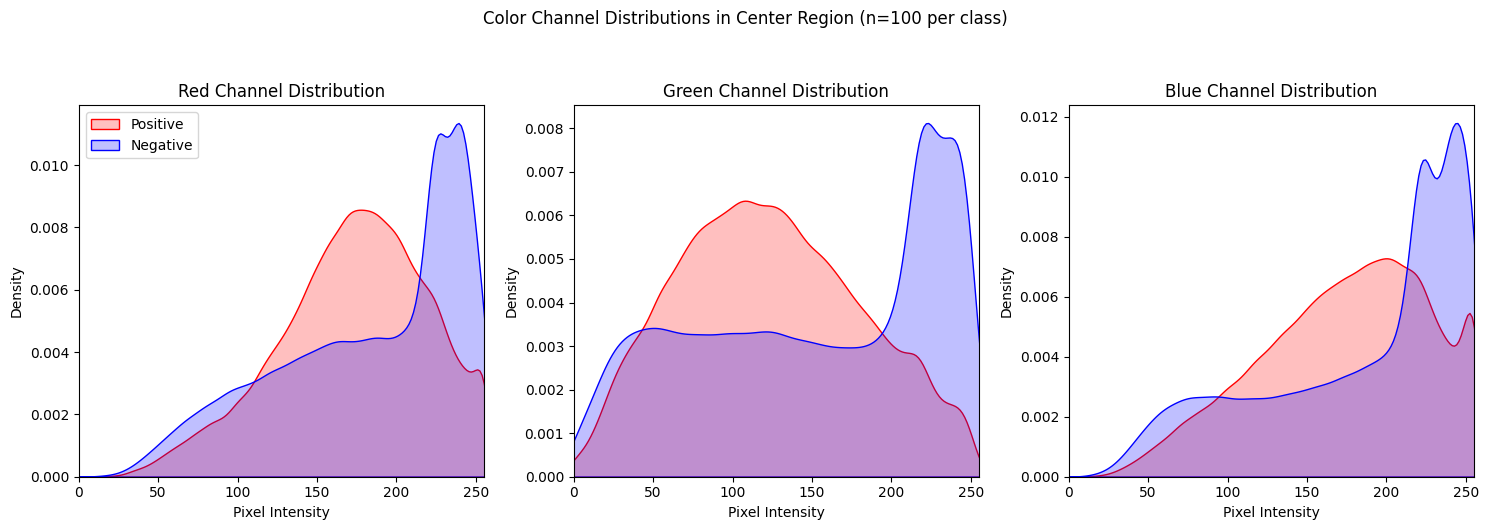

In [10]:
def compare_class_color_distributions(num_samples=100):
    plt.figure(figsize=(15, 5))

    # Sample images from both classes
    pos_samples = train_labels[train_labels['label'] == 1].sample(num_samples)
    neg_samples = train_labels[train_labels['label'] == 0].sample(num_samples)

    # Load and process images
    def get_center_pixels(samples):
        pixels = []
        for _, row in samples.iterrows():
            img = cv2.imread(os.path.join(train_dir, row['id'] + '.tif'))
            center_region = img[32:64, 32:64]  # Focus on diagnostic area
            pixels.append(center_region.reshape(-1, 3))
        return np.vstack(pixels)

    pos_pixels = get_center_pixels(pos_samples)
    neg_pixels = get_center_pixels(neg_samples)

    # Plot distributions
    channels = ['Red', 'Green', 'Blue']
    for i in range(3):
        plt.subplot(1, 3, i+1)
        sns.kdeplot(pos_pixels[:, i], color='r', label='Positive', fill=True)
        sns.kdeplot(neg_pixels[:, i], color='b', label='Negative', fill=True)
        plt.title(f'{channels[i]} Channel Distribution')
        plt.xlabel('Pixel Intensity')
        plt.xlim(0, 255)
        if i == 0: plt.legend()

    plt.suptitle("Color Channel Distributions in Center Region (n=100 per class)", y=1.05)
    plt.tight_layout()
    plt.show()

compare_class_color_distributions()

In [11]:
# Calculate class weights for loss function

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels['label']),
    y=train_labels['label'].values
)
class_weights = dict(enumerate(class_weights))
print(f"Class Weights: {class_weights}")

Class Weights: {0: 0.840380267057781, 1: 1.234472659537462}


In [12]:
# Split data into train/validation
train_df, val_df = train_test_split(
    train_labels,
    test_size=0.2,
    stratify=train_labels['label'],  # Preserve class balance
    random_state=42
)
print(f"Train size: {len(train_df)}, Validation size: {len(val_df)}")

Train size: 176020, Validation size: 44005


In [13]:
# Verify stratified split
def check_split_distribution(train_df, val_df):
    train_ratio = train_df['label'].mean()
    val_ratio = val_df['label'].mean()
    orig_ratio = train_labels['label'].mean()

    print(f"Original positive ratio: {orig_ratio:.4f}")
    print(f"Train positive ratio:    {train_ratio:.4f}")
    print(f"Val positive ratio:      {val_ratio:.4f}")

    assert np.isclose(train_ratio, orig_ratio, atol=0.005), "Train split not stratified!"
    assert np.isclose(val_ratio, orig_ratio, atol=0.005), "Val split not stratified!"

check_split_distribution(train_df, val_df)

Original positive ratio: 0.4050
Train positive ratio:    0.4050
Val positive ratio:      0.4050


In [14]:
def load_image(img_bytes):
    """Load an image from raw bytes using PIL and convert to a NumPy array."""
    try:
        img = Image.open(io.BytesIO(img_bytes.numpy()))
        img = img.convert('RGB')
        return np.array(img, dtype=np.uint8)
    except Exception as e:
        # If an error occurs, return a dummy image (zeros) of the expected shape.
        return np.zeros((96, 96, 3), dtype=np.uint8)

def parse_image(path, label):
    """Read and decode an image, then ensure its shape is set."""
    img_bytes = tf.io.read_file(path)
    image = tf.py_function(func=load_image, inp=[img_bytes], Tout=tf.uint8)
    # Explicitly set the shape
    image.set_shape((96, 96, 3))
    # Convert the label to float32
    label = tf.cast(label, tf.float32)
    return image, label

def create_dataset(df, batch_size=64, augment=False):
    """Create a TensorFlow dataset from a DataFrame of image paths and labels."""
    image_paths = df['id'].apply(lambda x: f"data/train/{x}.tif").tolist()
    labels = df['label'].values
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.map(parse_image, num_parallel_calls=tf.data.AUTOTUNE)

    # Optional: add any preprocessing/augmentation here
    if augment:
        def augment_fn(image, label):
            image = tf.image.random_flip_left_right(image)
            image = tf.image.random_brightness(image, 0.1)
            image = tf.image.random_contrast(image, 0.9, 1.1)
            return image, label
        dataset = dataset.map(augment_fn, num_parallel_calls=tf.data.AUTOTUNE)

    return dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)


# Create datasets
train_ds = create_dataset(train_df, augment=True)
val_ds = create_dataset(val_df)

Image batch shape: (64, 96, 96, 3)
Label batch shape: (64,)


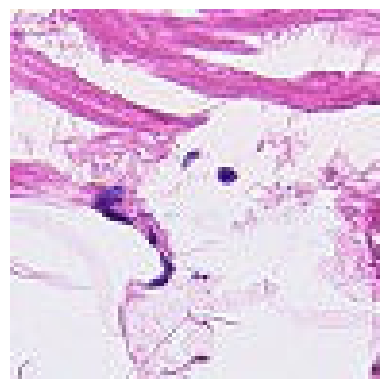

In [15]:
# Check first batch
sample_images, sample_labels = next(iter(train_ds))
print(f"Image batch shape: {sample_images.shape}")  # Should be (64, 96, 96, 3)
print(f"Label batch shape: {sample_labels.shape}")  # Should be (64,)

# Get the first sample from the batch
img = sample_images[0].numpy()

# Rescale the image to the [0,1] range for visualization
img_rescaled = (img - np.min(img)) / (np.max(img) - np.min(img))

plt.imshow(img_rescaled)
plt.axis('off')
plt.show()

In [16]:
# Select a sample of IDs (here, the first 10)
sample_ids = train_df['id'].head(10).tolist()

# Construct full file paths and check if they exist
for img_id in sample_ids:
    path = f"data/train/{img_id}.tif"
    exists = tf.io.gfile.exists(path)
    print(f"File path: {path} exists: {exists}")

File path: data/train/cffe7a3ffc48700045fd37f1f448b5a892ff4f2c.tif exists: True
File path: data/train/b5bef3e7d7e8cc81e38fa2288105fc1c130e771a.tif exists: True
File path: data/train/6fe4413a3a982af28a6e78d0f445073c509b4b33.tif exists: True
File path: data/train/d6b4fe580210f5ea61b7c109b5c2e5cc734c3010.tif exists: True
File path: data/train/1b6b051e370ca8468253d2e40f686c66eecb1619.tif exists: True
File path: data/train/161a3685624448cb26d6d36cdbe7744d735d34a8.tif exists: True
File path: data/train/50f1da97486b41cc774f99d57c2560d02ce75678.tif exists: True
File path: data/train/234c88b0c547bc1975da9abb8cd74cd89ed54c5a.tif exists: True
File path: data/train/f61d67a31b652cd928ef94e36ff3fb1db707f06f.tif exists: True
File path: data/train/ed5a70aba921910d1af57a8e468c7b90036eeb99.tif exists: True


In [17]:
# Choose a sample file path
sample_path = f"data/train/{sample_ids[0]}.tif"

# Read the file contents
img_bytes = tf.io.read_file(sample_path)

# Convert tensor to bytes (using .numpy() because we're in eager mode)
img_bytes = img_bytes.numpy()

try:
    # Attempt to load the image with PIL
    img = Image.open(io.BytesIO(img_bytes))
    # Convert to RGB (in case it's in a different mode)
    img = img.convert("RGB")
    # Convert to a NumPy array
    img_arr = np.array(img, dtype=np.uint8)
    print("Image loaded successfully with shape:", img_arr.shape)
except Exception as e:
    print("Error loading image:", e)

Image loaded successfully with shape: (96, 96, 3)


In [18]:
for images, labels in train_ds.take(1):
    print("Batch image shape:", images.shape)
    print("Batch labels shape:", labels.shape)


Batch image shape: (64, 96, 96, 3)
Batch labels shape: (64,)


2025-03-04 21:55:50.986262: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [19]:
import tensorflow as tf
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D,
                                     Dropout, Dense)
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam

def build_model(hp):
    """
    Build a binary classification model with two architecture options:
      - simple_cnn: A straightforward convolutional network.
      - ResNet50: A transfer learning model using ResNet50 with global average pooling.

    Hyperparameters:
      - architecture: Choice between 'simple_cnn' and 'ResNet50'
      - For simple_cnn:
          * conv_filters: Number of filters in first conv layer (16 to 64)
          * conv_filters2: Number of filters in second conv layer (32 to 128)
          * conv_filters3: Number of filters in third conv layer (64 to 256)
          * dense_units: Number of units in the dense layer (64 to 256)
      - For ResNet50:
          * dropout_rate: Dropout rate after base model (0.2 to 0.5)
          * dense_units_resnet: Number of units in the dense layer (64 to 256)
      - learning_rate: Learning rate for the Adam optimizer (1e-4 to 1e-2)
    """
    input_layer = Input(shape=(96, 96, 3))

    # Choose architecture option
    architecture = hp.Choice('architecture', ['simple_cnn', 'ResNet50'], default='simple_cnn')

    if architecture == 'simple_cnn':
        # First convolutional block
        conv_filters = hp.Int('conv_filters', min_value=16, max_value=64, step=16, default=32)
        x = Conv2D(conv_filters, (3, 3), activation='relu', padding='same')(input_layer)
        x = MaxPooling2D()(x)

        # Second convolutional block
        conv_filters2 = hp.Int('conv_filters2', min_value=32, max_value=128, step=32, default=64)
        x = Conv2D(conv_filters2, (3, 3), activation='relu', padding='same')(x)
        x = MaxPooling2D()(x)

        # Third convolutional block
        conv_filters3 = hp.Int('conv_filters3', min_value=64, max_value=256, step=64, default=128)
        x = Conv2D(conv_filters3, (3, 3), activation='relu', padding='same')(x)
        x = GlobalAveragePooling2D()(x)

        # Dense layer before output
        dense_units = hp.Int('dense_units', min_value=64, max_value=256, step=64, default=128)
        x = Dense(dense_units, activation='relu')(x)

    else:
        # ResNet50 branch with global average pooling to enforce fixed output shape.
        base_model = ResNet50(include_top=False, weights='imagenet',
                              input_tensor=input_layer, pooling='avg')
        base_model.trainable = False  # freeze base model

        x = base_model.output

        # Optional dropout for regularization
        dropout_rate = hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1, default=0.3)
        x = Dropout(dropout_rate)(x)

        # Dense layer for additional representation learning
        dense_units_resnet = hp.Int('dense_units_resnet', min_value=64, max_value=256, step=64, default=128)
        x = Dense(dense_units_resnet, activation='relu')(x)

    # Final output layer for binary classification
    output = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=input_layer, outputs=output)

    # Compile the model with a tunable learning rate
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG', default=1e-3)
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model


In [20]:
import keras_tuner as kt
import tensorflow as tf

# Instantiate the tuner (using RandomSearch here for simplicity)
tuner = kt.RandomSearch(
    build_model,                         # Our model-building function
    objective='val_accuracy',            # Metric to optimize
    max_trials=10,                       # Number of hyperparameter configurations to try
    executions_per_trial=1,              # One model per trial
    directory='kt_tuner_dir',            # Directory to save tuner results
    project_name='simple_cnn_resnet50'     # Name for this tuning session
)

# Print the search space summary
tuner.search_space_summary()

# Early stopping callback to avoid overfitting during hyperparameter search
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

# Run the hyperparameter search
tuner.search(
    train_ds,                # your training dataset
    validation_data=val_ds,  # your validation dataset
    epochs=10,               # Adjust number of epochs as needed
    callbacks=[early_stop]
)

# Print a summary of the search results
tuner.results_summary()

# Retrieve the best model and its hyperparameters
best_model = tuner.get_best_models(num_models=1)[0]
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best Hyperparameters:")
print(best_hp.values)

Trial 10 Complete [02h 35m 52s]
val_accuracy: 0.8808999061584473

Best val_accuracy So Far: 0.940779447555542
Total elapsed time: 20h 53m 14s
Results summary
Results in kt_tuner_dir/simple_cnn_resnet50
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 02 summary
Hyperparameters:
architecture: simple_cnn
conv_filters: 48
conv_filters2: 128
conv_filters3: 64
dense_units: 256
learning_rate: 0.0002770506871918118
Score: 0.940779447555542

Trial 05 summary
Hyperparameters:
architecture: simple_cnn
conv_filters: 48
conv_filters2: 32
conv_filters3: 64
dense_units: 128
learning_rate: 0.000743383954668978
dropout_rate: 0.2
dense_units_resnet: 192
Score: 0.9360072612762451

Trial 00 summary
Hyperparameters:
architecture: simple_cnn
conv_filters: 16
conv_filters2: 128
conv_filters3: 128
dense_units: 256
learning_rate: 0.0001281984668297353
Score: 0.9264401793479919

Trial 01 summary
Hyperparameters:
architecture: simple_cnn
conv_filters: 32
conv_filters2: 32
conv_filte

/Users/rohangupta/Library/Python/3.9/lib/python/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [21]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

# Retrieve the best model and hyperparameters from the tuner
best_model = tuner.get_best_models(num_models=1)[0]
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best Hyperparameters:", best_hp.values)

# Define callbacks
checkpoint_cb = ModelCheckpoint("best_model.h5", save_best_only=True, monitor='val_accuracy', mode='max')
reduce_lr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)

# Continue training the best model on your full training dataset
history = best_model.fit(
    train_ds,                # Your training dataset (ensure its shape is (96,96,3))
    validation_data=val_ds,  # Your validation dataset
    epochs=30,
    callbacks=[checkpoint_cb, reduce_lr_cb]
)

Best Hyperparameters: {'architecture': 'simple_cnn', 'conv_filters': 48, 'conv_filters2': 128, 'conv_filters3': 64, 'dense_units': 256, 'learning_rate': 0.0002770506871918118}
Epoch 1/30
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - accuracy: 0.9329 - loss: 0.1758

In [ ]:
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.legend()
plt.show()

In [ ]:
def parse_test_image(path):
    """Read and decode an image from the given path, then preprocess it."""
    img_bytes = tf.io.read_file(path)
    # Use tf.py_function to handle PIL image decoding
    image = tf.py_function(func=load_image, inp=[img_bytes], Tout=tf.uint8)
    # Explicitly set the shape
    image.set_shape((96, 96, 3))
    # Preprocess the image (normalize and standardize)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.per_image_standardization(image)
    return image, path  # Return the image and its file path

def create_test_dataset(batch_size=64):
    """Create a test dataset from image file paths in data/test."""
    # Get full paths for test images
    test_dir = "data/test"
    test_files = sorted([os.path.join(test_dir, fname)
                    for fname in os.listdir(test_dir)
                    if fname.endswith('.tif')])

    # Create a TensorFlow Dataset from the file paths
    ds = tf.data.Dataset.from_tensor_slices(test_files)
    ds = ds.map(parse_test_image, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

# Create test_ds
test_ds = create_test_dataset(batch_size=64)

# Check one batch from test_ds
for images, paths in test_ds.take(1):
    print("Image batch shape:", images.shape)
    print("Paths batch:", paths.numpy())

In [ ]:
# Generate predictions (probabilities)
test_preds = best_model.predict(test_ds)

In [ ]:
# Collect all test filenames (ensure they match prediction order)
filenames = []
for _, paths in test_ds.unbatch():  # Unbatch to iterate individual elements
    filenames.append(os.path.basename(paths.numpy().decode('utf-8')).replace('.tif', ''))

# Convert predictions to labels (example for binary classification)
pred_labels = (test_preds.squeeze() > 0.5).astype(int)  # Use .squeeze() if predictions have shape (N,1)

# Create DataFrame
submission_df = pd.DataFrame({
    'id': filenames,
    'label': pred_labels
})

# Save to CSV
submission_df.to_csv('submission.csv', index=False)
print("Submission file saved!")